<a href="https://colab.research.google.com/github/art-glazunov/MegaFon_RecSys_Workshop/blob/main/Part_6_1_Basic_DSSM_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MegaFon RecSys workshop
by Artyom Glazunov

## Part 6.1. Basic DSSM recommender

## The plan

- ### Data loading
- ### Useful classes and methods
- ### Data preparation
- ### Training
- ### Evaluation

In [ ]:
pip install -q lightfm==1.16

     |████████████████████████████████| 310 kB 12.7 MB/s 


In [ ]:
import random

import pandas as pd
import numpy as np
import scipy
from scipy.sparse import csr_matrix

import sklearn
from sklearn.base import TransformerMixin, BaseEstimator

from lightfm import data

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras

from sklearn.metrics import roc_auc_score

from matplotlib import pyplot as plt

import gc

### Data loading

In [ ]:
cd /content/drive/MyDrive/Colab_Notebooks/datafest_22/data

/content/drive/MyDrive/Colab_Notebooks/datafest_22/data


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
data_train_all = pd.read_csv("train.csv")
data_val = pd.read_csv("validation.csv")
data_test = pd.read_csv("test.csv")
cold_users_data = pd.read_csv("cold_users_data.csv")
cold_items_data = pd.read_csv("cold_items_data.csv")

In [ ]:
data_train_all.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
0,xvCGZ5McgEJlkYx2HNO1/CkD1CYjlA/gQL36iX8TYBY=,868uXMrBS8WwQulNX0W+vk6sJA6Hs35YNtFYceXgX/I=,radio,Radio,radio,0,255373.0,465,張震嶽,NaN,NaN,3.0,勇氣,TWA450479802,1,0,NaN,7,2013-05-14,2017-09-24
1,jOlB9i8NKGG2oudUKq9ObRyt3sXQnWWwcei1+s8sNIA=,a4TbK5V15pj3YZUOGa9h2U3t0OsE+3aiFw41mNlcgcw=,my library,Local playlist more,local-library,1,248790.0,465,吳汶芳 (Fang Wu),吳汶芳,吳汶芳,3.0,孤獨的總和 (Accumulated Loneliness),TWA211328806,13,31,female,9,2011-04-19,2017-06-20
2,fe+6batTKL/NxXhhzfDO3yBUmFmQUQAgRpYmF2T0t4E=,5RLsVkl6PTt3pIyWvojM0z2LblVysXHxoc7Mc4LIFL8=,my library,Local playlist more,local-library,1,178887.0,921,Noel Coward,NaN,NaN,52.0,Poor Little Rich Girl,USV291338277,5,33,female,9,2008-08-05,2017-10-06
3,GVcP7SPQ/IgiEt2uxaXaRH5lFA5tBe8T74/Etk7cnG8=,7Xxzo9Z584Z1AhkaLLWEcpzcEuxcquGE52Ztc4879YI=,discover,Online playlist more,online-playlist,1,275136.0,465,田馥甄 (Hebe),楊子樸,施人誠,3.0,寂寞寂寞就好,TWD951043107,1,0,NaN,7,2011-02-25,2017-09-12
4,XIfoYUt6vkAqVDRKJRVEHkV0jsaD+fif2EqxsobpEqg=,rA+H/y66yC2qK0v926aWRFWngwJmL+IhGhJN4fBS0XM=,radio,Radio,radio,0,243983.0,465,范瑋琪 (Christine Fan),陳小霞,姚若龍,3.0,最重要的決定,TWA211125202,5,22,female,7,2013-07-29,2017-09-30


### Useful classes and methods

In [ ]:
class ColumnCategorizer(TransformerMixin, BaseEstimator):
    """Creates new categorical features using continuous columns
    
    Requires 
    - quantiles list
    - columns to transform
    - new columns names
    """
    

    def __init__(self, qs, new_columns, old_columns):
        self.qs = qs #quantile list
        self.new_columns = new_columns #columns to create
        self.old_columns = old_columns #initial continuous columns
        self.transformers = {} #transformers storage
        

    def fit(self, X, y=None):
        """Fit transformers on a part of the columns
        X - train data
        """
        
        for column in self.old_columns:
            bins = np.unique([X[column].quantile(q=q) for q in self.qs])
            labels = [f"{column}_bin_{l_edge}_{r_edge}" for (l_edge, r_edge) in zip(bins[:-1], bins[1:])]
            self.transformers[column] = sklearn.preprocessing.FunctionTransformer(
                                             pd.cut, kw_args={'bins': bins, 
                                                              'include_lowest': True,
                                                              'labels': labels, 
                                                              'retbins': False}
                                                              ) 
            self.transformers[column].fit(X[column])
        return self
    

    def transform(self, X):
        """Transform data and return Pandas DataFrame
        X - data to transform
        """
        
        data_new = X.copy()
        for column_old, column_new in zip(self.old_columns, self.new_columns):
            data_new[column_new] = self.transformers[column_old].transform(data_new[column_old]).values
        return data_new


def names_to_cats(data_to_transform, cols):
    """Transform numeric categories using names of features
    
    data_to_transform - data to transform
    cols - columns to change
    """


    data_new = data_to_transform.copy()
    for col in cols:
        data_new[col] = data_new[col].apply(lambda x: f"{col}_{x}").values
    return data_new

In [ ]:
def get_lfm_dataset_obj(data_in, 
                        cat_cols_to_change,
                        user_fe_cols,
                        item_fe_cols,
                        user_id_column,
                        item_id_column,
                        user_identity_features=True,
                        item_identity_features=True):
    """Get lightfm dataset object from initial data
    It's useful for further getting mappings 

    data_in - initial pandas DataFrame to use
    cat_cols_to_change - columns to change via names_to_cats() method
    user_fe_cols - user features columns WITHOUT the id columns
    item_fe_cols - item features columns WITHOUT the id columns
    user_id_column - user id column
    item_id_column - item id column
    user_identity_features - consider user id as a feature?
    item_identity_features - consider item id as a feature?
    """

    data_prep = names_to_cats(data_in, cat_cols_to_change)

    user_fe_data = data_prep[user_fe_cols].values
    item_fe_data = data_prep[item_fe_cols].values
    user_id = data_prep[user_id_column].values.ravel()
    item_id = data_prep[item_id_column].values.ravel()


    dataset = data.Dataset(user_identity_features=user_identity_features,
                           item_identity_features=item_identity_features)
    dataset.fit(users=user_id, items=item_id,
                user_features=user_fe_data.T.ravel(),
                item_features=item_fe_data.T.ravel())
    
    return dataset


def get_mappings(dataset):
    """Prepare the mappings

    dataset - lightfm dataset object
    """

    result_dict = {}
    result_dict["user_id_mapping"] = dataset.mapping()[0]
    result_dict["item_id_mapping"] = dataset.mapping()[2]
    result_dict["user_fename_intid_mapping"] = dataset._user_feature_mapping
    result_dict["item_fename_intid_mapping"] = dataset._item_feature_mapping
    return result_dict


def get_user_item_interactions(data_in, dataset,
                               user_id_column,
                               item_id_column):
    """Get users-items interaction matrix

    data_in - train data
    dataset - lightfm dataset object
    user_id_column/item_id_column - user/item id columnd
    """
    
    user_id = data_in[user_id_column].values.ravel()
    item_id = data_in[item_id_column].values.ravel()
    interactions, _ = dataset.build_interactions(((x[0], x[1]) for x \
                                                    in zip(user_id, item_id)))
    return interactions.tocsr()


def get_interactions_ohe_id_mappings(mappings, 
                                     users_unique, 
                                     items_unique,
                                     user_id_column,
                                     item_id_column):
    """Get mappings between interactions ids 
    and ohe features ids

    mappings - mappings from lfm dataset
    users_unique - unique users features DataFrame (WITH id column)
    items_unique - unique items features DataFrame (WITH id column)
    user_id_column - user id column name
    item_id_column - item id column name
    """
    
    result_dict = {}

    users_iid_eid_mapping = {value: key for key, value in mappings["user_id_mapping"].items()}
    items_iid_eid_mapping = {value: key for key, value in mappings["item_id_mapping"].items()}

    users_eid_oheid_mapping = {value: key for key, value in users_unique[user_id_column].to_dict().items()}
    items_eid_oheid_mapping = {value: key for key, value in items_unique[item_id_column].to_dict().items()}

    result_dict["users_iid_oheid_mapping"] = {key: users_eid_oheid_mapping[value] \
                                              for key, value in users_iid_eid_mapping.items()}
    result_dict["items_iid_oheid_mapping"] = {key: items_eid_oheid_mapping[value] \
                                              for key, value in items_iid_eid_mapping.items()}
    
    return result_dict


def get_sparse_ohe_vectors(data_in, fename_intid_mapping):
    """Get sparse one-hot encoding matrix

    data_in - our data with features
    fename_intid_mapping - mapping with ids and category names
    """

    row_ids = []
    col_ids = []
    for ind_r, features in enumerate(data_in.values):
        for cat_name in features:
            if cat_name in fename_intid_mapping:
                row_ids.append(ind_r)
                col_ids.append(fename_intid_mapping[cat_name])
    values = [1] * len(col_ids)

    result =  sklearn.preprocessing.\
                      normalize(scipy.sparse.csr.\
                                csr_matrix((values, (row_ids, col_ids)),
                                            shape = (data_in.shape[0],
                                                    len(fename_intid_mapping))),
                                norm="l1", copy=False)
    return result

### Data preparation

In [ ]:
user_fe_cols = ["city", "gender", "bd"]
item_fe_cols = ["genre_ids", "artist_name", "composer", "language"]
user_id_column = "msno"
item_id_column = "song_id"

#Other lists of features
cat_cols_to_change = ["genre_ids", "language", "city"] #columns to add name to value
numeric_cols = ["bd"] #this columns will be categorized

#Columns in the result dataframe with targets and scores
result_cols = [user_id_column, item_id_column, "target"]

In [ ]:
#####
#quantile list for categorization
QS = np.linspace(0, 1, 11, endpoint=True)
#####

categorizer = ColumnCategorizer(qs=QS, 
                                new_columns=numeric_cols, 
                                old_columns=numeric_cols)
categorizer.fit(data_train_all)

ColumnCategorizer(new_columns=['bd'], old_columns=['bd'],
                  qs=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

Numeric features preparation (categorization)

In [ ]:
data_train_fin = categorizer.transform(data_train_all)
data_test_fin = categorizer.transform(data_test)
data_val_fin = categorizer.transform(data_val)
cold_users_data_fin = categorizer.transform(cold_users_data)
cold_items_data_fin = categorizer.transform(cold_items_data)
data_train_fin.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
0,xvCGZ5McgEJlkYx2HNO1/CkD1CYjlA/gQL36iX8TYBY=,868uXMrBS8WwQulNX0W+vk6sJA6Hs35YNtFYceXgX/I=,radio,Radio,radio,0,255373.0,465,張震嶽,NaN,NaN,3.0,勇氣,TWA450479802,1,bd_bin_-43.0_0.0,NaN,7,2013-05-14,2017-09-24
1,jOlB9i8NKGG2oudUKq9ObRyt3sXQnWWwcei1+s8sNIA=,a4TbK5V15pj3YZUOGa9h2U3t0OsE+3aiFw41mNlcgcw=,my library,Local playlist more,local-library,1,248790.0,465,吳汶芳 (Fang Wu),吳汶芳,吳汶芳,3.0,孤獨的總和 (Accumulated Loneliness),TWA211328806,13,bd_bin_30.0_36.0,female,9,2011-04-19,2017-06-20
2,fe+6batTKL/NxXhhzfDO3yBUmFmQUQAgRpYmF2T0t4E=,5RLsVkl6PTt3pIyWvojM0z2LblVysXHxoc7Mc4LIFL8=,my library,Local playlist more,local-library,1,178887.0,921,Noel Coward,NaN,NaN,52.0,Poor Little Rich Girl,USV291338277,5,bd_bin_30.0_36.0,female,9,2008-08-05,2017-10-06
3,GVcP7SPQ/IgiEt2uxaXaRH5lFA5tBe8T74/Etk7cnG8=,7Xxzo9Z584Z1AhkaLLWEcpzcEuxcquGE52Ztc4879YI=,discover,Online playlist more,online-playlist,1,275136.0,465,田馥甄 (Hebe),楊子樸,施人誠,3.0,寂寞寂寞就好,TWD951043107,1,bd_bin_-43.0_0.0,NaN,7,2011-02-25,2017-09-12
4,XIfoYUt6vkAqVDRKJRVEHkV0jsaD+fif2EqxsobpEqg=,rA+H/y66yC2qK0v926aWRFWngwJmL+IhGhJN4fBS0XM=,radio,Radio,radio,0,243983.0,465,范瑋琪 (Christine Fan),陳小霞,姚若龍,3.0,最重要的決定,TWA211125202,5,bd_bin_21.0_24.0,female,7,2013-07-29,2017-09-30


Get the interactions matrix and prepare train categorical columns

In [ ]:
lfm_dataset = get_lfm_dataset_obj(data_train_fin[data_train_fin.target==1], 
                                  cat_cols_to_change,
                                  user_fe_cols,
                                  item_fe_cols,
                                  user_id_column,
                                  item_id_column,
                                  user_identity_features=True,
                                  item_identity_features=False)

In [ ]:
interactions = get_user_item_interactions(data_train_fin[data_train_fin.target==1], lfm_dataset,
                                          user_id_column,
                                          item_id_column)
interactions

<24035x180541 sparse matrix of type '<class 'numpy.int32'>'
	with 2539875 stored elements in Compressed Sparse Row format>

In [ ]:
mappings = get_mappings(lfm_dataset)
len(mappings["user_fename_intid_mapping"]), len(mappings["item_fename_intid_mapping"])

(24067, 64079)

Get unique users and items entries

In [ ]:
data_train_prep = names_to_cats(data_train_fin[data_train_fin.target==1], cols=cat_cols_to_change)
users_unique = data_train_prep[user_fe_cols + [user_id_column]].drop_duplicates().reset_index(drop=True)
items_unique = data_train_prep[item_fe_cols + [item_id_column]].drop_duplicates().reset_index(drop=True)
users_unique.head()

,city,gender,bd,msno
0,city_13,female,bd_bin_30.0_36.0,jOlB9i8NKGG2oudUKq9ObRyt3sXQnWWwcei1+s8sNIA=
1,city_5,female,bd_bin_30.0_36.0,fe+6batTKL/NxXhhzfDO3yBUmFmQUQAgRpYmF2T0t4E=
2,city_1,NaN,bd_bin_-43.0_0.0,GVcP7SPQ/IgiEt2uxaXaRH5lFA5tBe8T74/Etk7cnG8=
3,city_1,NaN,bd_bin_-43.0_0.0,73q3/E5FIUwCSo9uPyhKcc1FNO9DqnaZqX7uDK5Rr7E=
4,city_1,NaN,bd_bin_-43.0_0.0,M6fFPRO/pOaaWoergvHHsFzEUbW4YU6DKxqBDyYSbYU=


Get the mapping for the batch generation

In [ ]:
interactions_ohe_id_mappings = get_interactions_ohe_id_mappings(mappings, 
                                                                users_unique, 
                                                                items_unique,
                                                                user_id_column,
                                                                item_id_column)
users_iid_oheid_mapping = interactions_ohe_id_mappings['users_iid_oheid_mapping']
items_iid_oheid_mapping = interactions_ohe_id_mappings['items_iid_oheid_mapping']
len(users_iid_oheid_mapping), len(items_iid_oheid_mapping)

(24035, 180541)

In [ ]:
del data_train_all, data_train_prep, data_train_fin
gc.collect()

125

Final users and items features

In [ ]:
data_users_ohe = get_sparse_ohe_vectors(users_unique,
                                        mappings["user_fename_intid_mapping"])
data_items_ohe = get_sparse_ohe_vectors(items_unique,
                                        mappings["item_fename_intid_mapping"])
data_users_ohe.shape, data_items_ohe.shape

((24035, 24067), (180541, 64079))

### Training

First of all, choose embeddings size

In [ ]:
####
EMBEDDINGS_DIM = 150
####

### Now let's describe the training and inference processes

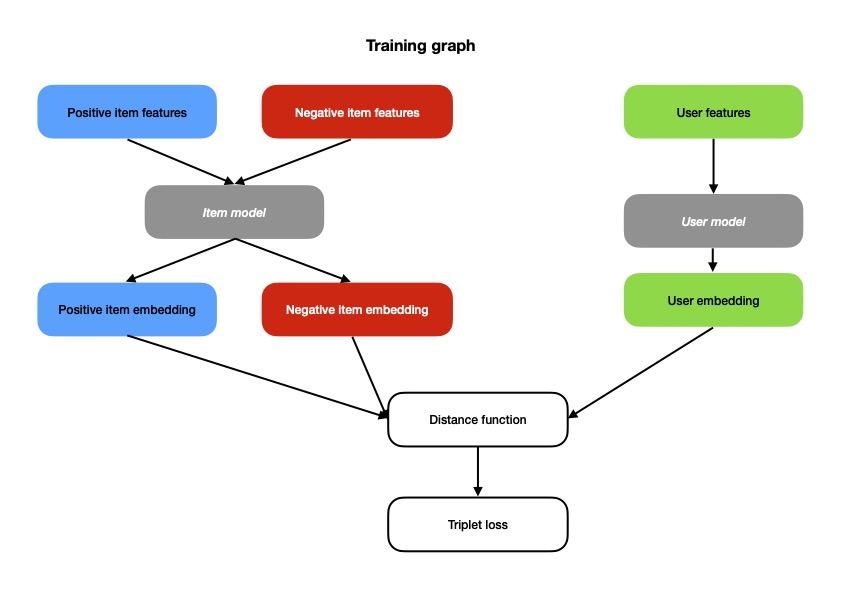

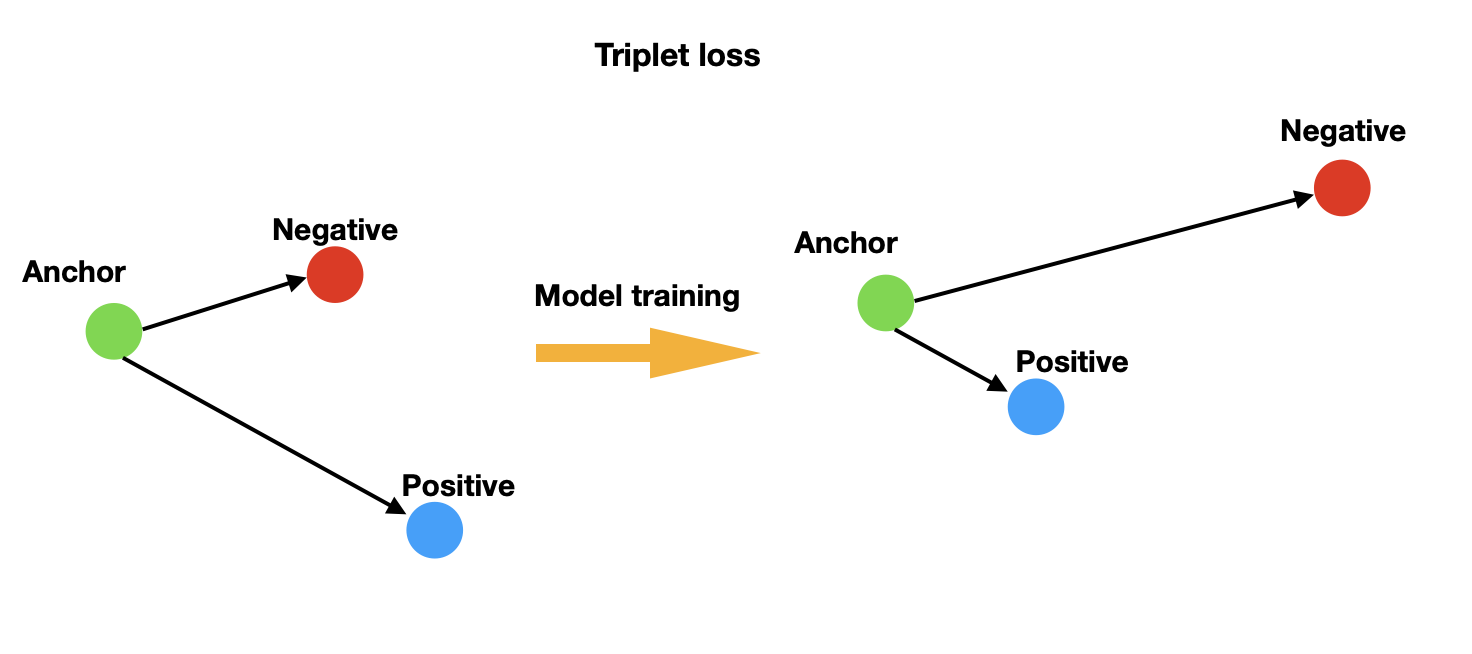

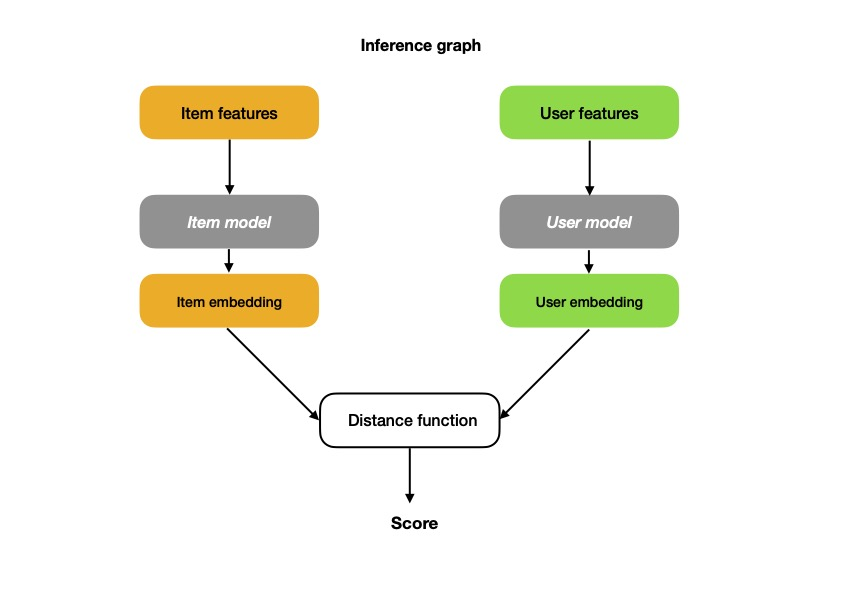

### ... and initialize the methods for those processes

In [ ]:
def triplet_loss(y_true, y_pred, n=EMBEDDINGS_DIM, alpha=0.5):
    """Basic triplet loss implementation, 
    input params and their order should fit the keras loss interface

    y_true- keras interface param, only a patch for correct work
    y_pred - keras interface param, concatenated vector
    n - embedding dim size
    alpha - training parameter
    """

    input_vec = y_pred
    anchor = input_vec[:, 0 : n]
    positive = input_vec[:, n : 2*n]
    negative = input_vec[:, 2*n : 3*n]

    p_dist = K.sum(K.square(anchor - positive), axis=1)
    n_dist = K.sum(K.square(anchor - negative), axis=1)

    loss = K.maximum(p_dist - n_dist + alpha, 0.0)
 
    return loss

In [ ]:
def batch_generator_v1(items, users, 
                      interactions, 
                      users_iid_oheid_mapping,
                      items_iid_oheid_mapping,
                      batch_size=512):
    """Batch generator method
    The function randomly chooses the user id, positive and negative items ids
    "batch_size" times

    items - items features
    users - users features
    interactions - users-items sparse interactions matrix
    users_iid_oheid_mapping/items_iid_oheid_mapping - interaction matrix ids 
          -> features ids mappings 
    batch_size - the numbers of triplets in a batch
    """


    while True:
        uid_features = []
        pos = []
        neg = []
        uid_sample = random.sample(list(range(0, interactions.shape[0] - 1)), batch_size)
        user_sample_interactions = interactions[uid_sample].toarray()
        prob_dists = user_sample_interactions / np.sum(user_sample_interactions, axis=1, keepdims=True)
        pos_i_sample = []
        for i in range(batch_size):
            pos_i_sample.append(np.random.choice(range(interactions.shape[1]), p=prob_dists[i]))         
        neg_i_sample = random.choices(range(interactions.shape[1]), k=batch_size)

        user_oheid_sample = []
        pos_i_oheid_sample = []
        neg_i_oheid_sample = []
        for i in range(batch_size):
            user_oheid_sample.append(users_iid_oheid_mapping[uid_sample[i]])
            pos_i_oheid_sample.append(items_iid_oheid_mapping[pos_i_sample[i]])
            neg_i_oheid_sample.append(items_iid_oheid_mapping[neg_i_sample[i]])
        
        #users features
        uid_features.extend(users[user_oheid_sample].toarray())
        #items features
        pos.extend(items[pos_i_oheid_sample].toarray())
        neg.extend(items[neg_i_oheid_sample].toarray())
        
        gc.collect()
            
        yield [np.array(uid_features), np.array(pos), np.array(neg)], [np.zeros((batch_size, 1))]

### Check out how the generator works

In [ ]:
generator_ex = batch_generator_v1(items=data_items_ohe, 
                                  users=data_users_ohe, 
                                  interactions=interactions,
                                  users_iid_oheid_mapping=users_iid_oheid_mapping,
                                  items_iid_oheid_mapping=items_iid_oheid_mapping)

result = next(generator_ex)


print(f"Users batch shape: {result[0][0].shape}")
print(f"Positive items batch shape: {result[0][1].shape}")
print(f"Negative items batch shape: {result[0][2].shape}")
print()
print(f"Patch to fit the keras interface: {result[1][0].shape}")

Users batch shape: (512, 24067)
Positive items batch shape: (512, 64079)
Negative items batch shape: (512, 64079)

Patch to fit the keras interface: (512, 1)


### Initialize our simple dssm model graph

Input and output sizes:

In [ ]:
#######
#Dence layers size parameters
size_param_1 = 3
size_param_2 = 2
#######

ITEM_MODEL_INPUT_SHAPE = (data_items_ohe.shape[1], ) 
USER_MODEL_INPUT_SHAPE = (data_users_ohe.shape[1], ) 

print(f"EMBEDDINGS_DIM: {EMBEDDINGS_DIM}")
print(f"USER_MODEL_SHAPE: {USER_MODEL_INPUT_SHAPE}")
print(f"ITEM_MODEL_SHAPE: {ITEM_MODEL_INPUT_SHAPE}")

EMBEDDINGS_DIM: 150
USER_MODEL_SHAPE: (24067,)
ITEM_MODEL_SHAPE: (64079,)


Here, we'll use a simple fully connected architecture. For example, the user model inputs and outputs:

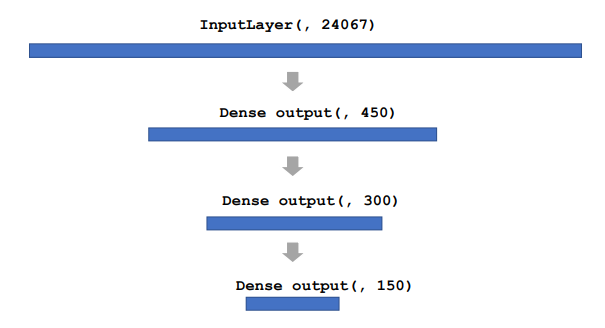

In [ ]:
# User model
u2v = keras.Sequential(
    [
        keras.layers.Input(shape=USER_MODEL_INPUT_SHAPE, name="u2v_input"),
        keras.layers.Dense(size_param_1 * EMBEDDINGS_DIM, activation='relu', name="u2v_1st_layer"),
        keras.layers.Dense(size_param_2 * EMBEDDINGS_DIM, activation='relu', name="u2v_2nd_layer"),
        keras.layers.Dense(EMBEDDINGS_DIM, activation='linear', name="u2v_3rd_layer_output")
    ],
    name="u2v_model"
)

#Item model
i2v = keras.Sequential(
    [
        keras.layers.Input(shape=ITEM_MODEL_INPUT_SHAPE, name="i2v_input"),
        keras.layers.Dense(size_param_1 * EMBEDDINGS_DIM, activation='relu', name="i2v_1st_layer"),
        keras.layers.Dense(size_param_2 * EMBEDDINGS_DIM, activation='relu', name="i2v_2nd_layer"),
        keras.layers.Dense(EMBEDDINGS_DIM, activation='linear', name="i2v_3rd_layer_output")
    ],
    name="i2v_model"
)

ancor_inp = keras.layers.Input(shape=USER_MODEL_INPUT_SHAPE)
pos_inp = keras.layers.Input(shape=ITEM_MODEL_INPUT_SHAPE)
neg_inp = keras.layers.Input(shape=ITEM_MODEL_INPUT_SHAPE)
ancor = u2v(ancor_inp)
positive = i2v(pos_inp)
negative = i2v(neg_inp)
merged_vecs = keras.layers.Concatenate(name="anc_pos_neg_concat")([ancor, positive, negative])
model = keras.models.Model([ancor_inp, pos_inp, neg_inp], merged_vecs, name="my_model")

### Define the optimizer, some callbacks and compile our model

In [ ]:
name = 'dssm_linear_basic'
optimizer = keras.optimizers.Adam(learning_rate=0.001)

lr_reduce = keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=1, factor=0.7, verbose=1)
saving = keras.callbacks.ModelCheckpoint(filepath="../models/" + name + '/best_model.h5', monitor="loss")

model.compile(loss=triplet_loss, optimizer=optimizer)

In [ ]:
model.summary()

Model: "my_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 24067)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64079)]      0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 64079)]      0           []                               
                                                                                                  
 u2v_model (Sequential)         (None, 150)          11011050    ['input_1[0][0]']                
                                                                                           

In [ ]:
i2v.summary()

Model: "i2v_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 i2v_1st_layer (Dense)       (None, 450)               28836000  
                                                                 
 i2v_2nd_layer (Dense)       (None, 300)               135300    
                                                                 
 i2v_3rd_layer_output (Dense  (None, 150)              45150     
 )                                                               
                                                                 
Total params: 29,016,450
Trainable params: 29,016,450
Non-trainable params: 0
_________________________________________________________________


In [ ]:
u2v.summary()

Model: "u2v_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 u2v_1st_layer (Dense)       (None, 450)               10830600  
                                                                 
 u2v_2nd_layer (Dense)       (None, 300)               135300    
                                                                 
 u2v_3rd_layer_output (Dense  (None, 150)              45150     
 )                                                               
                                                                 
Total params: 11,011,050
Trainable params: 11,011,050
Non-trainable params: 0
_________________________________________________________________


### Let's train our model

In [ ]:
model.fit(batch_generator_v1(items=data_items_ohe, 
                            users=data_users_ohe, 
                            interactions=interactions,
                            users_iid_oheid_mapping=users_iid_oheid_mapping,
                            items_iid_oheid_mapping=items_iid_oheid_mapping,
                            batch_size=256), 
          steps_per_epoch=20, 
          epochs=5, 
          initial_epoch=0,
          callbacks=[lr_reduce, saving]
        )

Epoch 1/5
20/20 [==============================] - 112s 6s/step - loss: 0.3232 - lr: 0.0010
Epoch 2/5
20/20 [==============================] - 105s 5s/step - loss: 0.1770 - lr: 0.0010
Epoch 3/5
20/20 [==============================] - 106s 5s/step - loss: 0.1702 - lr: 0.0010
Epoch 4/5
20/20 [==============================] - 105s 5s/step - loss: 0.1589 - lr: 0.0010
Epoch 5/5
20/20 [==============================] - 105s 5s/step - loss: 0.1569 - lr: 0.0010


### Evaluation

#### Useful evaluation methods

In [ ]:
def get_result_df(data_val, result_cols, scores):
    """Get resulting dataframe

    data_val - initial data with features
    result_cols - columns without scores (ids, other useful info)
    scores - predicted scores
    """
    
    real_pred_df = data_val[result_cols].copy()
    real_pred_df['score'] = scores
    return real_pred_df


def users_roc_auc_scores(real_pred_data, id_col="msno", 
                         target_col="target", score_col="score"):
    """Compute ROC AUC scores
    for users

    real_pred_data - data with target and score
    id_col - user_id column
    target_col, score_col - columns with target values and model's scores
    """

    roc_auc_scores = []
    for _, data_us in real_pred_data.groupby(id_col):
        roc_auc_scores.append(roc_auc_score(data_us[target_col], data_us[score_col]))
    return roc_auc_scores


def users_rr_scores(real_pred_data, id_col="msno", 
        target_col="target", score_col="score"):
    """Compute RR scores for users

    real_pred_data - data with target and score
    id_col - user_id column
    target_col, score_col - columns with target values and model's scores
    """

    rr_scores = []
    for _, data_us in real_pred_data.groupby(id_col):
        data_us_sorted = data_us.sort_values(by=[score_col], ascending=False)\
                                .reset_index(drop=True)
        rr_score = 1 / ((data_us_sorted.target == 1).argmax() + 1)
        rr_scores.append(rr_score)
    return rr_scores


def precision_at_k(real_pred_data, k=5, id_col="msno", 
        target_col="target", score_col="score"):
    """Compute precision@k scores for users

    real_pred_data - data with target and score
    k - size of the top 
    id_col- user_id column
    target_col, score_col - columns with target values and model's scores
    """

    precision_scores = []
    for _, data_us in real_pred_data.groupby(id_col):
        data_us_sorted = data_us.sort_values(by=[score_col], ascending=False)
        precision_score = data_us_sorted.iloc[:k].target.sum() / k
        precision_scores.append(precision_score)
    return precision_scores


def test_data_preprocessing(data_test, id="msno", k=10, 
                            min_prop=0.05, max_prop=0.95):
    """Pick only users 
    with both positive and negative responces

    data_test - data to transform
    id - user id column name
    k - minimum number of songs that a user interacted with
    min/max_prop - minimum/maximum limits for the proportion of 
        positive interactions in users histories
    """

    data_new = data_test.copy()
    val_users = []
    for user_id, data_us in data_new.groupby([id]):
        pos_cnt = data_us.target.sum()
        cnt = data_us.shape[0]
        pos_prop = pos_cnt / cnt
        if cnt >= k and pos_prop > min_prop and pos_prop < max_prop:
            val_users.append(user_id)    

    data_prep = data_new[data_new[id].isin(val_users)].reset_index(drop=True)
    return data_prep



def dssm_evaluation(i2v,u2v, data_test,
                    cat_cols_to_change,
                    mappings,
                    result_cols,
                    user_id_column,
                    batch_size=512,
                    n=100, k=5,
                    min_prop=0.25, max_prop=0.75):
    """DSSM model evaluation

    i2v/u2v - user/item models
    data_test - test dataframe (initial dataframe with ALL the columns, 
        the needed features will be automatically selected via the mappings)
    cat_cols_to_change - columns to change via names_to_cats() method
    mappings - mappings from get_mappings() method
    result_cols - columns in the resulting dataframe (without score column)
    user_id_column - user id column
    batch_size - the size of chunk for the models processing
    n - test_data_preprocessing() parameter (the min size of user's history)
    k - precision_at_k() method parameter
    min/max_prop - minimum/maximum limits for the proportion of 
        positive interactions in users histories
    """

    data_select = test_data_preprocessing(data_test, id=user_id_column, k=n,
                                          min_prop=min_prop, max_prop=max_prop)
    data_test_prep = names_to_cats(data_select, cols=cat_cols_to_change)
    data_users_ohe = get_sparse_ohe_vectors(data_test_prep, mappings["user_fename_intid_mapping"])
    data_items_ohe = get_sparse_ohe_vectors(data_test_prep, mappings["item_fename_intid_mapping"])
    
    data_size = data_test_prep.shape[0]
    start = 0
    stop = batch_size
    rows_left = data_size
    sims = []
    while rows_left > 0:
        users_feats = data_users_ohe[start:stop]
        items_feats = data_items_ohe[start:stop]
        users_vecs = u2v.predict(users_feats)
        items_vecs = i2v.predict(items_feats)
        dists = np.linalg.norm(users_vecs - items_vecs, axis=1)
        sims.extend(1 / dists)
        
        start += batch_size
        stop += batch_size
        rows_left -= batch_size
        gc.collect()

    test_real_pred = get_result_df(data_test_prep, result_cols, sims)
    roc_auc_scores = users_roc_auc_scores(test_real_pred)
    rr_scores = users_rr_scores(test_real_pred)
    p_at_k_scores = precision_at_k(test_real_pred, k=k)
    print(f"Users mean AUC ROC on test: {np.mean(roc_auc_scores)}")
    print(f"Users mean reciprocal rank on test: {np.mean(rr_scores)}")
    print(f"Users mean precision@{k} on test: {np.mean(p_at_k_scores)}")
    plt.figure()
    plt.hist(roc_auc_scores)
    plt.title("USERS AUC ROC SCORES")
    plt.grid()
    plt.figure()
    plt.hist(rr_scores)
    plt.title(f"USERS RECIPROCAL RANK SCORES")
    plt.grid()
    plt.figure()
    plt.hist(p_at_k_scores)
    plt.title(f"USERS PRECISION@{k} SCORES")
    plt.grid()
    return test_real_pred

### So, let's evaluate our model on different sets

Users mean AUC ROC on test: 0.5811760512670814
Users mean reciprocal rank on test: 0.7958898544581037
Users mean precision@5 on test: 0.6439169139465876


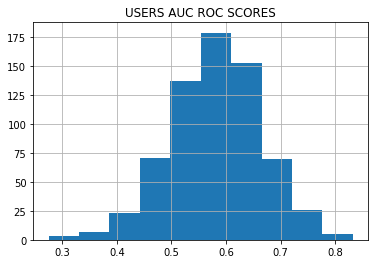

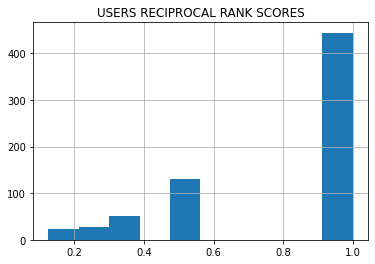

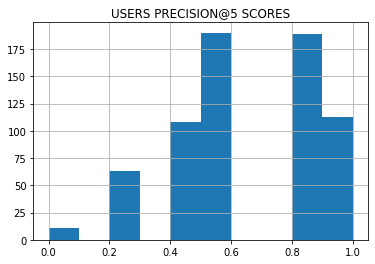

In [ ]:
val_real_pred = dssm_evaluation(i2v, u2v, data_val_fin,
                                cat_cols_to_change, 
                                mappings,
                                result_cols,
                                user_id_column,
                                batch_size=300000,
                                n=100, k=5,
                                min_prop=0.25, max_prop=0.75)

In [ ]:
val_real_pred.head()

,msno,song_id,target,score
0,BGo4Oilb0i8FCeZOLUPIFGkW3RWDwNuMoixfq+Mmekk=,6DacXyIfstje6EynOjN4eLKbp95UWPZ0N+8EctMV5bw=,0,0.750632
1,y+rCSbVwnDOFjVwVE2s0m6oMKuTdift2dczOFoCUls8=,DpMV43WD2Ev8pT8uIcVrfw0tqU4r/T7RQuBhgelYefA=,0,0.741841
2,nIbXtHhahnJnRyA8FjlOQDlCJ9HGVCds8PGG9oMsf6I=,t+IofZpz3Fa/kh9rA1huUtyeJITnrToaH35PdyQUzcw=,1,0.666024
3,YMK9IDA6yFUBJxwm1SxYNM6nFrMcDAXunV/8dzGFdlo=,D1tFsBLd9VWbonfb6Vek0BI2EJB6udLOuV/x+ptYpOI=,0,0.800900
4,w4SNbHDAMuMbulkgcHGYOl/datijVua3CR5D73DylLs=,7vGvrf5l1XzNbeLZXzQgaNvc2VBmncarpN3LQpLUZiY=,1,0.764327


Users mean AUC ROC on test: 0.5801055413777827
Users mean reciprocal rank on test: 0.8061746031746031
Users mean precision@5 on test: 0.6619259259259258


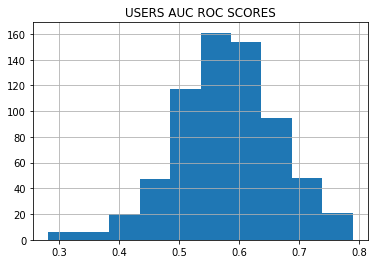

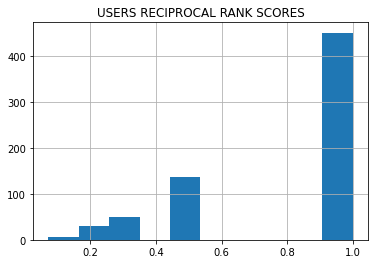

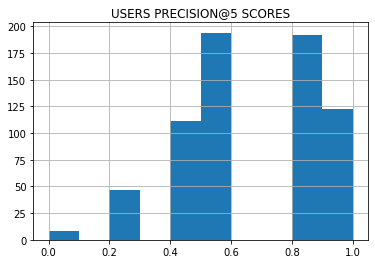

In [ ]:
_ = dssm_evaluation(i2v, u2v, data_test_fin,
                    cat_cols_to_change, 
                    mappings,
                    result_cols,
                    user_id_column,
                    batch_size=300000,
                    n=100, k=5,
                    min_prop=0.25, max_prop=0.75)

Users mean AUC ROC on test: 0.5773377133381055
Users mean reciprocal rank on test: 0.7783091464637768
Users mean precision@5 on test: 0.6341984732824427


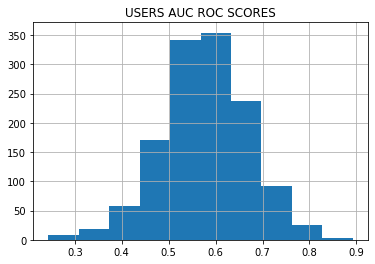

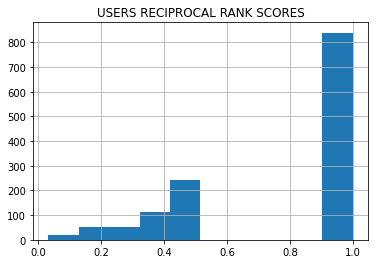

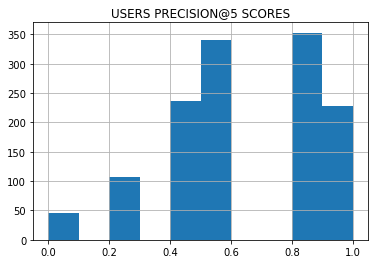

In [ ]:
_ = dssm_evaluation(i2v, u2v, cold_users_data_fin,
                    cat_cols_to_change, 
                    mappings,
                    result_cols,
                    user_id_column,
                    batch_size=300000,
                    n=100, k=5,
                    min_prop=0.25, max_prop=0.75)

Users mean AUC ROC on test: 0.5742935344627186
Users mean reciprocal rank on test: 0.7703370424567608
Users mean precision@5 on test: 0.6143098591549296


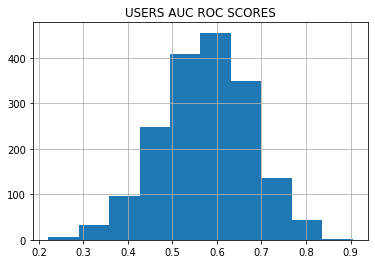

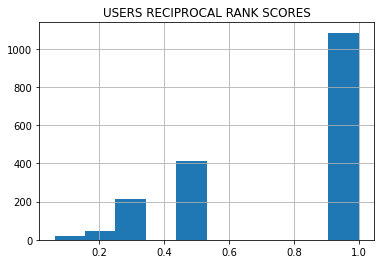

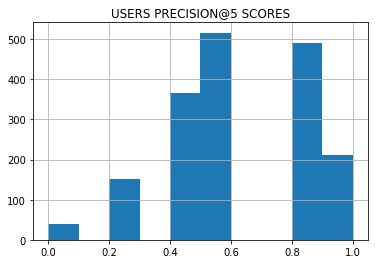

In [ ]:
_ = dssm_evaluation(i2v, u2v, cold_items_data_fin,
                    cat_cols_to_change, 
                    mappings,
                    result_cols,
                    user_id_column,
                    batch_size=300000,
                    n=40, k=5,
                    min_prop=0.25, max_prop=0.75)

### Although our model is simple and has been trained for a limited time, we have some interesting results. To get better quality, try using more complex architectures and be patient :)

### Stay tuned :)